# Построение моделей решающих дерьевьев и ансамблей.

## Импорт библиотек

In [147]:
import numpy as np
import pandas as pd
import json
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_text, export_graphviz
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, StackingClassifier
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from scipy.stats import randint, uniform
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from search_hyperparameters import search_hyperparameters
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, accuracy_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, auc

## Классификация (бинарная True\False)

### Загрузка датасета

In [148]:
data_classifier = pd.read_csv('csgo_filtred.csv')

X_cl = data_classifier.drop(columns=['bomb_planted'], axis=1)
y_cl = data_classifier['bomb_planted']

<Axes: ylabel='bomb_planted'>

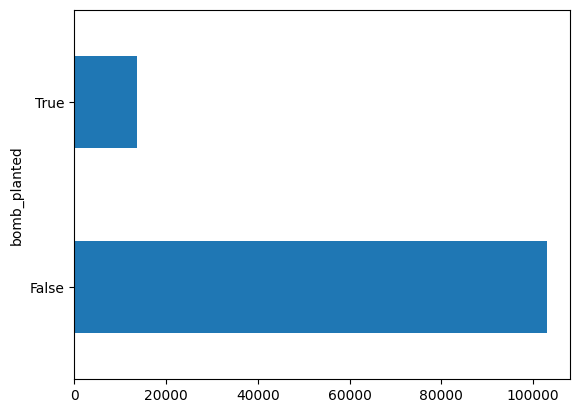

In [149]:
y_cl.value_counts().plot.barh()

In [150]:
y_cl.value_counts()

bomb_planted
False    102945
True      13684
Name: count, dtype: int64

In [151]:
X_cl['map'].value_counts()

map
de_inferno     22806
de_dust2       21040
de_nuke        17879
de_mirage      17641
de_overpass    13375
de_train       12800
de_vertigo     10733
unknown          211
de_cache         144
Name: count, dtype: int64

In [152]:
X_cl['map'] = X_cl['map'].str.strip().str.lower()
mapping = {
    'de_inferno': 1,
    'de_dust2': 2,
    'de_nuke': 3,
    'de_mirage': 4,
    'de_overpass': 5,
    'de_train': 6,
    'de_vertigo': 7,
    'unknown': 8,
    'de_cache': 9
}

X_cl['map'] = X_cl['map'].map(mapping)
X_cl['map'].value_counts()

map
1    22806
2    21040
3    17879
4    17641
5    13375
6    12800
7    10733
8      211
9      144
Name: count, dtype: int64

### Разделение на тренировочную и тестовую выборки

In [153]:
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X_cl, y_cl, stratify=y_cl, train_size=0.8, test_size=0.2)
X_test_cl.shape, X_train_cl.shape

((23326, 20), (93303, 20))

In [154]:
X_train_cl_search, X_test_cl_search, y_train_cl_search, y_test_cl_search = train_test_split(X_cl, y_cl, stratify=y_cl, train_size=0.1, test_size=0.01)
X_test_cl_search.shape, X_train_cl_search.shape

((1167, 20), (11662, 20))

In [155]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Т.к. классы несбалансированы, был построен пайплайн включаюший в себя маштабирование выборок и её балансировка при помощи SMOTEENN.

In [156]:
from build_pipeline import build_pipeline

In [157]:
def metrics(pred_array, true_array):
    print(f'F1: {f1_score(true_array, pred_array)}')
    print(f'accuracy: {accuracy_score(true_array, pred_array)}')
    print(f'precision: {precision_score(true_array, pred_array)}')
    print(f'recall: {recall_score(true_array, pred_array)}')
    print(f'roc_auc_score: {roc_auc_score(true_array, pred_array)}')

In [158]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="Could not find the number of physical cores.*loky.backend.context"
)

In [159]:
y_test_cl.shape

(23326,)

### Поиск гиперпараметров для моделей классификации

In [160]:
from parameters import parameters

models = ['DecisionTreeClassifier', 'RandomForestClassifier', 'BaggingClassifier', 'GradientBoostingClassifier', 'StackingClassifier', 'CatBoostClassifier', 'XGBClassifier', 'LGBMClassifier']
methods = ['GridSearchCV', 'RandomizedSearchCV']

In [161]:
def convert(o):
    if isinstance(o, np.generic):
        return o.item()
    raise TypeError

file_path = 'best_params.json'

try:
    with open(file_path, 'r') as f:
        best_params = json.load(f)
except (FileNotFoundError, json.JSONDecodeError):
    best_params = {}

In [162]:
for model in models:
    if model not in best_params:
        best_params[model] = {}
    for method in methods:
        if method in best_params[model]:
            print(f'Пропускаем {model}, {method}, так как уже есть в файле')
            continue
        if model == 'RandomForestClassifier' and method == 'GridSearchCV':
            continue
        print(f'Сейчас на {model}, {method}')
        searcher = search_hyperparameters(
            model_name=model,
            method_search=method,
            X_train=X_train_cl_search,
            y_train=y_train_cl_search,
            param_grid=parameters[model][method],
            n_jobs=-1,
            cv=3,
            scoring='f1'
        )
        best_params[model][method] = {
            'params': searcher['best_params'],
            'score': searcher['best_score']
        }

        with open(file_path, 'w') as f:
            json.dump(best_params, f, indent=4, default=convert)

Пропускаем DecisionTreeClassifier, GridSearchCV, так как уже есть в файле
Пропускаем DecisionTreeClassifier, RandomizedSearchCV, так как уже есть в файле
Пропускаем RandomForestClassifier, RandomizedSearchCV, так как уже есть в файле
Пропускаем BaggingClassifier, GridSearchCV, так как уже есть в файле
Пропускаем BaggingClassifier, RandomizedSearchCV, так как уже есть в файле
Пропускаем GradientBoostingClassifier, GridSearchCV, так как уже есть в файле
Пропускаем GradientBoostingClassifier, RandomizedSearchCV, так как уже есть в файле
Пропускаем StackingClassifier, GridSearchCV, так как уже есть в файле
Пропускаем StackingClassifier, RandomizedSearchCV, так как уже есть в файле
Пропускаем CatBoostClassifier, GridSearchCV, так как уже есть в файле
Пропускаем CatBoostClassifier, RandomizedSearchCV, так как уже есть в файле
Пропускаем XGBClassifier, GridSearchCV, так как уже есть в файле
Пропускаем XGBClassifier, RandomizedSearchCV, так как уже есть в файле
Пропускаем LGBMClassifier, GridS

In [163]:
with open('best_params.json', 'r') as f:
    best_params = json.load(f)

### DesicionTreeRegressor

In [164]:
dt_classifier = build_pipeline(DecisionTreeClassifier(
    max_depth=best_params['DecisionTreeClassifier']['GridSearchCV']['params']['model__max_depth'],
    class_weight=best_params['DecisionTreeClassifier']['GridSearchCV']['params']['model__class_weight'],
    criterion=best_params['DecisionTreeClassifier']['GridSearchCV']['params']['model__criterion'],
    min_samples_leaf=best_params['DecisionTreeClassifier']['GridSearchCV']['params']['model__min_samples_leaf'],
))

# Hold-out
dt_classifier.fit(X_train_cl, y_train_cl)
y_pred_cl_dt = dt_classifier.predict(X_test_cl)
metrics(pred_array=y_pred_cl_dt, true_array=y_test_cl)

# K-fold
k_fold_cl_dt = cross_validate(dt_classifier, X_train_cl, y_train_cl, cv=kf, scoring='f1')
df_k_fold_cs_dt = pd.DataFrame(k_fold_cl_dt)
df_k_fold_cs_dt 

F1: 0.9124087591240876
accuracy: 0.9783932092943497
precision: 0.8700696055684455
recall: 0.959079283887468
roc_auc_score: 0.9700199955306008


,fit_time,score_time,test_score
0,0.173664,0.014004,0.913612
1,0.184042,0.014004,0.912630
2,0.178041,0.011002,0.913591
3,0.169666,0.012002,0.917031
4,0.172036,0.011004,0.912372


In [165]:
df_k_fold_cs_dt.mean()

fit_time      0.175490
score_time    0.012403
test_score    0.913847
dtype: float64

In [166]:
joblib.dump(dt_classifier, 'models/classifier/dt_classifier_model')

['models/classifier/dt_classifier_model']

In [167]:
dt_classifier = joblib.load(r'models/classifier/dt_classifier_model')

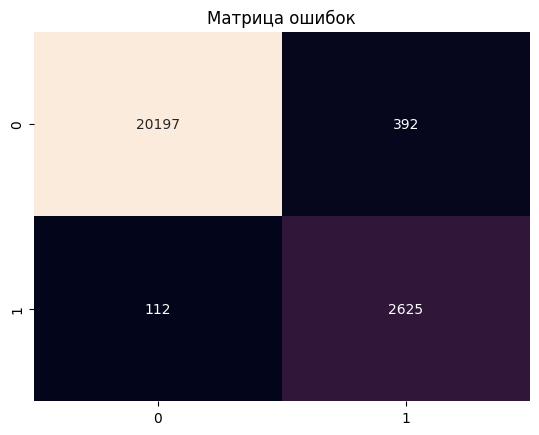

In [168]:
cm_dt_cl = confusion_matrix(y_test_cl, y_pred_cl_dt)

plt.figure()
sns.heatmap(cm_dt_cl, annot=True, fmt='d', cbar=False)
plt.title('Матрица ошибок')
plt.show()

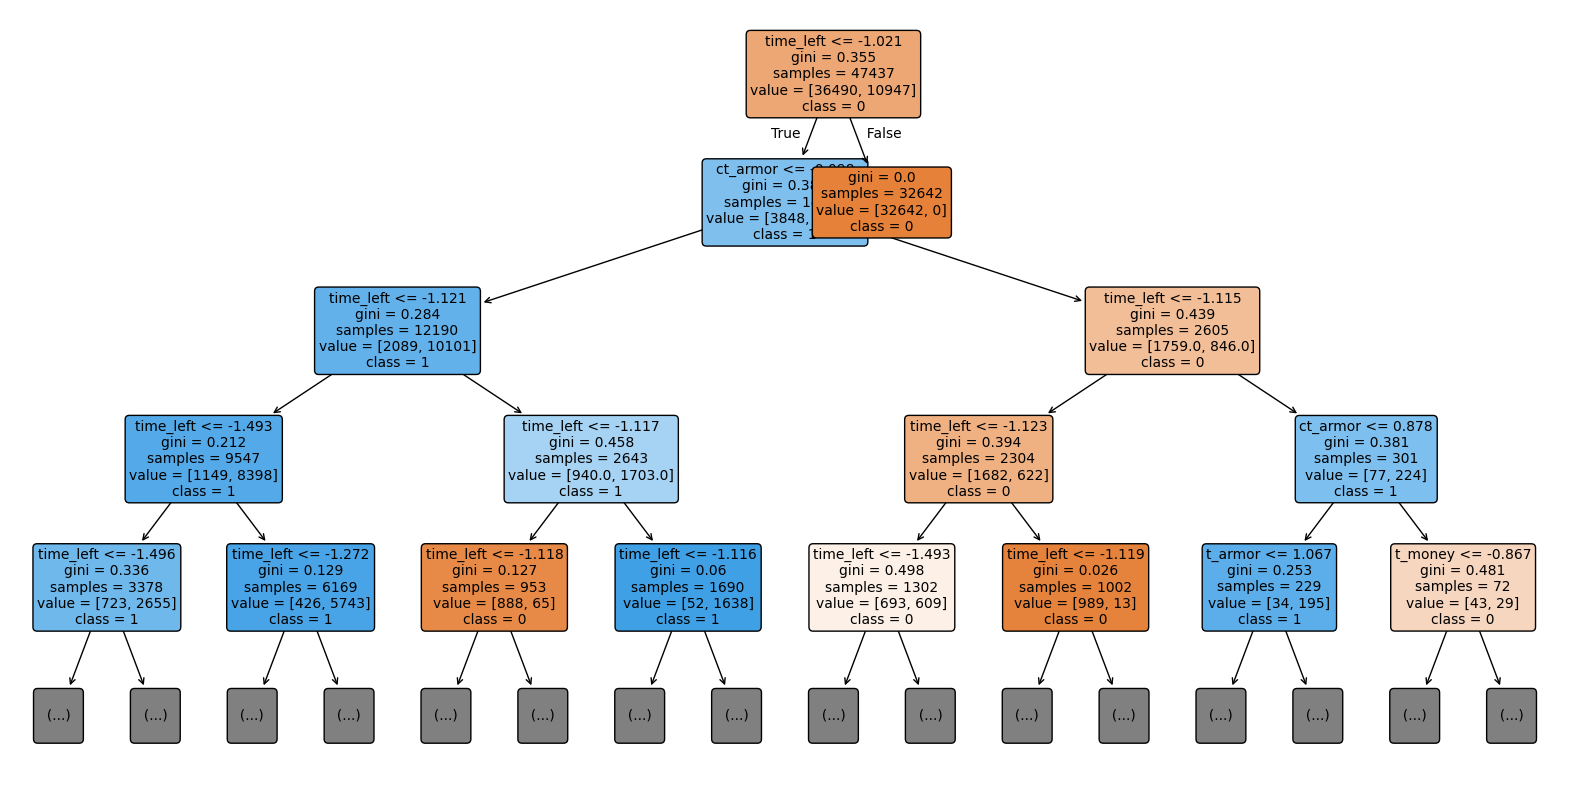

In [169]:
plt.figure(figsize=(20, 10))
tree.plot_tree(
    dt_classifier.named_steps['model'],
    feature_names=X_cl.columns.to_list(),
    class_names=['0','1'],
    filled=True,
    rounded=True,
    max_depth=4,
    fontsize=10
)
plt.show()

In [170]:
decision_tree = dt_classifier.named_steps['model']
feature_names = X_cl.columns
tree_rules = export_text(decision_tree, feature_names=list(feature_names))
print("Правила дерева решений:")
print(tree_rules)

Правила дерева решений:
|--- time_left <= -1.02
|   |--- ct_armor <= -0.10
|   |   |--- time_left <= -1.12
|   |   |   |--- time_left <= -1.49
|   |   |   |   |--- time_left <= -1.50
|   |   |   |   |   |--- health_lead <= -0.77
|   |   |   |   |   |   |--- t_armor <= -1.59
|   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |--- t_armor >  -1.59
|   |   |   |   |   |   |   |--- players_alive_lead <= -1.25
|   |   |   |   |   |   |   |   |--- time_left <= -1.58
|   |   |   |   |   |   |   |   |   |--- time_left <= -1.66
|   |   |   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |   |   |   |--- time_left >  -1.66
|   |   |   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |   |--- time_left >  -1.58
|   |   |   |   |   |   |   |   |   |--- time_left <= -1.50
|   |   |   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |   |   |   |--- time_left >  -1.50
|   |   |   |   |   |   |   |   |   |   |--- clas

### RandomForestClassifier

In [171]:
rf_classifier = build_pipeline(RandomForestClassifier(
    bootstrap=best_params['RandomForestClassifier']['RandomizedSearchCV']['params']['model__bootstrap'],
    ccp_alpha=best_params['RandomForestClassifier']['RandomizedSearchCV']['params']['model__ccp_alpha'],
    criterion=best_params['RandomForestClassifier']['RandomizedSearchCV']['params']['model__criterion'],
    max_depth=best_params['RandomForestClassifier']['RandomizedSearchCV']['params']['model__max_depth'],
    max_features=best_params['RandomForestClassifier']['RandomizedSearchCV']['params']['model__max_features'],
    min_samples_leaf=best_params['RandomForestClassifier']['RandomizedSearchCV']['params']['model__min_samples_leaf'],
    min_samples_split=best_params['RandomForestClassifier']['RandomizedSearchCV']['params']['model__min_samples_split'],
    n_estimators=best_params['RandomForestClassifier']['RandomizedSearchCV']['params']['model__n_estimators'],
    oob_score=best_params['RandomForestClassifier']['RandomizedSearchCV']['params']['model__oob_score'],
))

# Hold-out
rf_classifier.fit(X_train_cl, y_train_cl)
y_pred_cl_rf = rf_classifier.predict(X_test_cl)
metrics(pred_array=y_pred_cl_rf, true_array=y_test_cl)

# K-fold
k_fold_cl_rf = cross_validate(rf_classifier, X_train_cl, y_train_cl, cv=kf, scoring='f1')
df_k_fold_cl_rf = pd.DataFrame(k_fold_cl_rf)
df_k_fold_cl_rf

F1: 0.9133561643835616
accuracy: 0.9783074680613907
precision: 0.8594908153399936
recall: 0.9744245524296675
roc_auc_score: 0.9766240980614509


,fit_time,score_time,test_score
0,12.445321,0.086020,0.912775
1,11.934257,0.089020,0.919629
2,11.796247,0.083645,0.921952
3,11.752765,0.086021,0.921848
4,11.664541,0.083018,0.913686


In [172]:
joblib.dump(rf_classifier, 'models/classifier/rf_classifier_model')

['models/classifier/rf_classifier_model']

In [173]:
rf_classifier = joblib.load(r'models/classifier/rf_classifier_model')

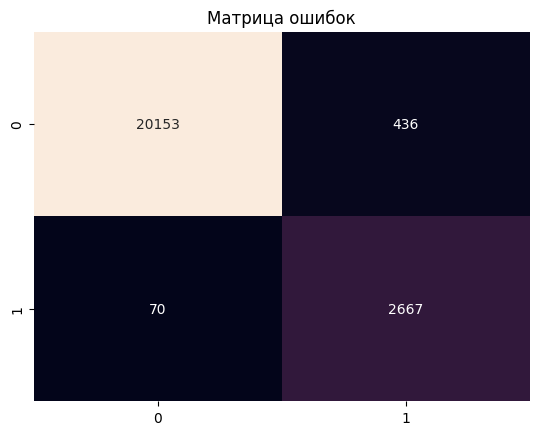

In [174]:
cm_rf_cl = confusion_matrix(y_test_cl, y_pred_cl_rf)

plt.figure()
sns.heatmap(cm_rf_cl, annot=True, fmt='d', cbar=False)
plt.title('Матрица ошибок')
plt.show()

### BaggingClassifier

In [175]:
bc_classifier = build_pipeline(BaggingClassifier(
    bootstrap=best_params['BaggingClassifier']['GridSearchCV']['params']['model__bootstrap'],
    max_features=best_params['BaggingClassifier']['GridSearchCV']['params']['model__max_features'],
    max_samples=best_params['BaggingClassifier']['GridSearchCV']['params']['model__max_samples'],
    n_estimators=best_params['BaggingClassifier']['GridSearchCV']['params']['model__n_estimators'],
))

# Hold-out
bc_classifier.fit(X_train_cl, y_train_cl)
y_pred_cl_bc = bc_classifier.predict(X_test_cl)
metrics(pred_array=y_pred_cl_bc, true_array=y_test_cl)

# K-fold
k_fold_cl_bc = cross_validate(bc_classifier, X_train_cl, y_train_cl, cv=kf, scoring='f1')
df_k_fold_cl_bc = pd.DataFrame(k_fold_cl_bc)
df_k_fold_cl_bc

F1: 0.8547273982056591
accuracy: 0.9639029409242905
precision: 0.8097417456685191
recall: 0.9050054804530507
roc_auc_score: 0.9383689794804959


,fit_time,score_time,test_score
0,12.969070,0.244162,0.858955
1,11.786763,0.237055,0.918231
2,12.389768,0.231558,0.915801
3,11.914248,0.214049,0.918317
4,12.262758,0.230160,0.911404


In [176]:
joblib.dump(bc_classifier, 'models/classifier/bc_classifier_model')

['models/classifier/bc_classifier_model']

In [177]:
bc_classifier = joblib.load((r'models/classifier/bc_classifier_model'))

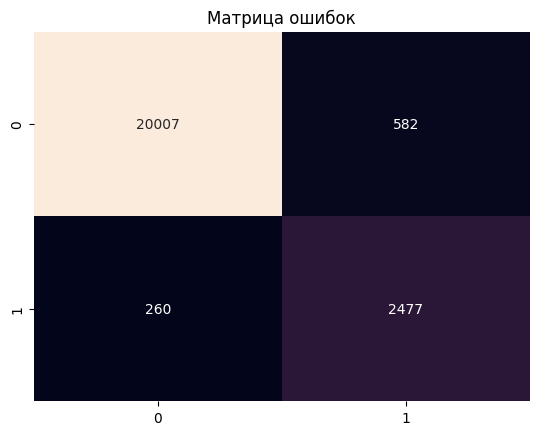

In [178]:
cm_bc_cl = confusion_matrix(y_test_cl, y_pred_cl_bc)

plt.figure()
sns.heatmap(cm_bc_cl, annot=True, fmt='d', cbar=False)
plt.title('Матрица ошибок')
plt.show()

### GradientBoostingClassifier

In [179]:
gb_classifier = build_pipeline(GradientBoostingClassifier(
    learning_rate=best_params['GradientBoostingClassifier']['RandomizedSearchCV']['params']['model__learning_rate'],
    max_depth=best_params['GradientBoostingClassifier']['RandomizedSearchCV']['params']['model__max_depth'],
    max_features=best_params['GradientBoostingClassifier']['RandomizedSearchCV']['params']['model__max_features'],
    min_samples_leaf=best_params['GradientBoostingClassifier']['RandomizedSearchCV']['params']['model__min_samples_leaf'],
    n_estimators=best_params['GradientBoostingClassifier']['RandomizedSearchCV']['params']['model__n_estimators'],
    subsample=best_params['GradientBoostingClassifier']['RandomizedSearchCV']['params']['model__subsample'],
))

# Hold-out
gb_classifier.fit(X_train_cl, y_train_cl)
y_pred_cl_gb = gb_classifier.predict(X_test_cl)
metrics(y_pred_cl_gb, y_test_cl)

# K-fold
k_fold_cl_gb = cross_validate(gb_classifier, X_train_cl, y_train_cl, cv=kf, scoring='f1')
df_k_fold_cl_gb = pd.DataFrame(k_fold_cl_gb)
df_k_fold_cl_gb

F1: 0.9175824175824175
accuracy: 0.9794221040898569
precision: 0.8655652737285391
recall: 0.9762513701132627
roc_auc_score: 0.9780474879610948


,fit_time,score_time,test_score
0,10.524133,0.038009,0.919521
1,10.291618,0.040010,0.928664
2,10.070673,0.037009,0.922482
3,10.594175,0.039010,0.928695
4,10.715944,0.042011,0.923742


In [180]:
joblib.dump(gb_classifier, 'models/classifier/gb_classifier_model')

['models/classifier/gb_classifier_model']

In [181]:
gb_classifier = joblib.load((r'models/classifier/gb_classifier_model'))

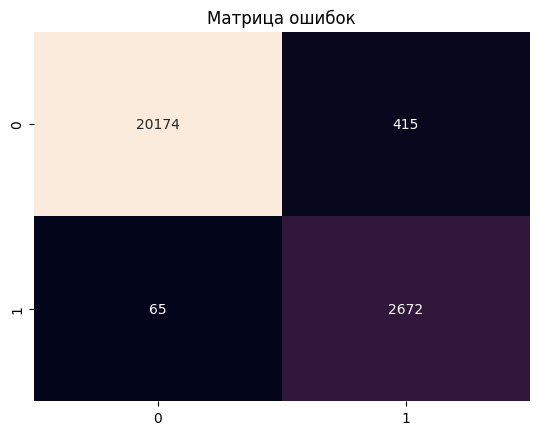

In [182]:
cm_gb_cl = confusion_matrix(y_test_cl, y_pred_cl_gb)

plt.figure()
sns.heatmap(cm_gb_cl, annot=True, fmt='d', cbar=False)
plt.title('Матрица ошибок')
plt.show()

### StackingClassifier

In [183]:
estimators = [
    ('rf', RandomForestClassifier(
        bootstrap=best_params['RandomForestClassifier']['RandomizedSearchCV']['params']['model__bootstrap'],
        ccp_alpha=best_params['RandomForestClassifier']['RandomizedSearchCV']['params']['model__ccp_alpha'],
        criterion=best_params['RandomForestClassifier']['RandomizedSearchCV']['params']['model__criterion'],
        max_depth=best_params['RandomForestClassifier']['RandomizedSearchCV']['params']['model__max_depth'],
        max_features=best_params['RandomForestClassifier']['RandomizedSearchCV']['params']['model__max_features'],
        min_samples_leaf=best_params['RandomForestClassifier']['RandomizedSearchCV']['params']['model__min_samples_leaf'],
        min_samples_split=best_params['RandomForestClassifier']['RandomizedSearchCV']['params']['model__min_samples_split'],
        n_estimators=best_params['RandomForestClassifier']['RandomizedSearchCV']['params']['model__n_estimators'],
        oob_score=best_params['RandomForestClassifier']['RandomizedSearchCV']['params']['model__oob_score'],
    )),
    ('dt', DecisionTreeClassifier(
        max_depth=best_params['DecisionTreeClassifier']['GridSearchCV']['params']['model__max_depth'],
        class_weight=best_params['DecisionTreeClassifier']['GridSearchCV']['params']['model__class_weight'],
        criterion=best_params['DecisionTreeClassifier']['GridSearchCV']['params']['model__criterion'],
        min_samples_leaf=best_params['DecisionTreeClassifier']['GridSearchCV']['params']['model__min_samples_leaf'],
    ))
]

st_classifier = build_pipeline(StackingClassifier(
    estimators=estimators,
    passthrough=best_params['StackingClassifier']['GridSearchCV']['params']['model__passthrough']
))

# Hold-out
st_classifier.fit(X_train_cl, y_train_cl)
y_pred_cl_st = st_classifier.predict(X_test_cl)
metrics(y_pred_cl_st, y_test_cl)

# K-fold
k_fold_cl_st = cross_validate(st_classifier, X_train_cl, y_train_cl, cv=kf, scoring='f1')
df_k_fold_cl_st = pd.DataFrame(k_fold_cl_st)
df_k_fold_cl_st

F1: 0.9169562195969423
accuracy: 0.9795078453228158
precision: 0.8741305067903279
recall: 0.9641943734015346
roc_auc_score: 0.9728689580349749


,fit_time,score_time,test_score
0,58.605108,0.089020,0.919939
1,57.511476,0.089646,0.925038
2,57.301166,0.088020,0.925093
3,58.204830,0.088021,0.923989
4,58.818380,0.087020,0.916395


In [184]:
joblib.dump(st_classifier, 'models/classifier/st_classifier_model')

['models/classifier/st_classifier_model']

In [185]:
st_classifier = joblib.load((r'models/classifier/st_classifier_model'))

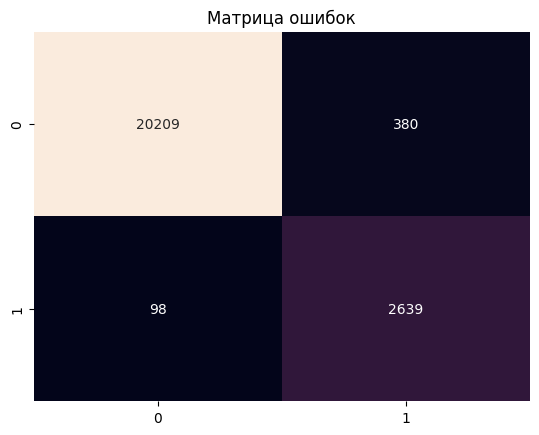

In [186]:
cm_st_cl = confusion_matrix(y_test_cl, y_pred_cl_st)

plt.figure()
sns.heatmap(cm_st_cl, annot=True, fmt='d', cbar=False)
plt.title('Матрица ошибок')
plt.show()

### CatBoost

In [187]:
cb_classifier = build_pipeline(CatBoostClassifier(
    depth=best_params['CatBoostClassifier']['GridSearchCV']['params']['model__depth'],
    iterations=best_params['CatBoostClassifier']['GridSearchCV']['params']['model__iterations'],
    l2_leaf_reg=best_params['CatBoostClassifier']['GridSearchCV']['params']['model__l2_leaf_reg'],
    learning_rate=best_params['CatBoostClassifier']['GridSearchCV']['params']['model__learning_rate'],
    verbose=0
))

# Hold-out
cb_classifier.fit(X_train_cl, y_train_cl)
y_pred_cl_cb = cb_classifier.predict(X_test_cl)
metrics(y_pred_cl_cb, y_test_cl)

# K-fold
k_fold_cl_cb = cross_validate(cb_classifier, X_train_cl, y_train_cl, cv=kf, scoring='f1')
df_k_fold_cl_cb = pd.DataFrame(k_fold_cl_cb)
df_k_fold_cl_cb

F1: 0.9139344262295082
accuracy: 0.9783932092943497
precision: 0.8579672972106445
recall: 0.9777128242601388
roc_auc_score: 0.9780982402907377


,fit_time,score_time,test_score
0,3.325694,0.029007,0.915932
1,3.373688,0.020003,0.918687
2,3.251359,0.020005,0.915131
3,3.434118,0.020005,0.921581
4,3.275631,0.021004,0.917835


In [188]:
joblib.dump(cb_classifier, 'models/classifier/cb_classifier_model')

['models/classifier/cb_classifier_model']

In [189]:
cb_classifier = joblib.load('models/classifier/cb_classifier_model')

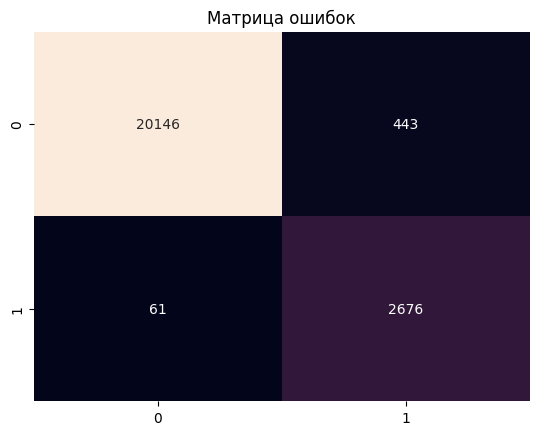

In [190]:
cm_cb_cl = confusion_matrix(y_test_cl, y_pred_cl_cb)

plt.figure()
sns.heatmap(cm_cb_cl, annot=True, fmt='d', cbar=False)
plt.title('Матрица ошибок')
plt.show()

### XGBoost

In [191]:
xgb_classifier = build_pipeline(XGBClassifier(
    learning_rate=best_params['XGBClassifier']['GridSearchCV']['params']['model__learning_rate'],
    max_depth=best_params['XGBClassifier']['GridSearchCV']['params']['model__max_depth'],
    n_estimators=best_params['XGBClassifier']['GridSearchCV']['params']['model__n_estimators'],
    subsample=best_params['XGBClassifier']['GridSearchCV']['params']['model__subsample'],
))

# Hold-out
xgb_classifier.fit(X_train_cl, y_train_cl)
y_pred_cl_xgb = xgb_classifier.predict(X_test_cl)
metrics(y_pred_cl_xgb, y_test_cl)

# K-fold
k_fold_cl_xgb = cross_validate(xgb_classifier, X_train_cl, y_train_cl, cv=kf, scoring='f1')
df_k_fold_cl_xgb = pd.DataFrame(k_fold_cl_xgb)
df_k_fold_cl_xgb

F1: 0.8956477902873466
accuracy: 0.9733773471662522
precision: 0.8291848164281269
recall: 0.9736938253562295
roc_auc_score: 0.9735145507372726


,fit_time,score_time,test_score
0,0.272739,0.016003,0.902243
1,0.216049,0.018004,0.900400
2,0.265567,0.020005,0.896609
3,0.236954,0.019004,0.908550
4,0.211553,0.021005,0.902828


In [192]:
joblib.dump(xgb_classifier, 'models/classifier/xgb_classifier_model')

['models/classifier/xgb_classifier_model']

In [193]:
xgb_classifier = joblib.load('models/classifier/xgb_classifier_model')

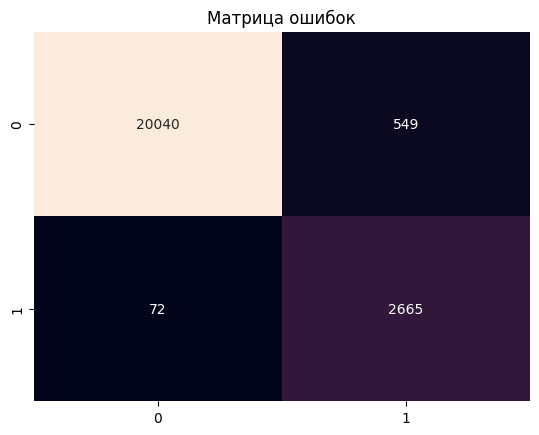

In [194]:
cm_xgb_cl = confusion_matrix(y_test_cl, y_pred_cl_xgb)

plt.figure()
sns.heatmap(cm_xgb_cl, annot=True, fmt='d', cbar=False)
plt.title('Матрица ошибок')
plt.show()

### LightGBM

In [195]:
lb_classifier = build_pipeline(LGBMClassifier(
    learning_rate=best_params['LGBMClassifier']['GridSearchCV']['params']['model__learning_rate'],
    n_estimators=best_params['LGBMClassifier']['GridSearchCV']['params']['model__n_estimators'],
    num_leaves=best_params['LGBMClassifier']['GridSearchCV']['params']['model__num_leaves'],
    subsample=best_params['LGBMClassifier']['GridSearchCV']['params']['model__subsample'],
    verbose=-1
))

# Hold-out
lb_classifier.fit(X_train_cl, y_train_cl)
y_pred_cl_lb = lb_classifier.predict(X_test_cl)
metrics(y_pred_cl_lb, y_test_cl)

# K-fold
k_fold_cl_lb = cross_validate(lb_classifier, X_train_cl, y_train_cl, cv=kf, scoring='f1')
df_k_fold_cl_lb = pd.DataFrame(k_fold_cl_lb)
df_k_fold_cl_lb

F1: 0.9117748026089941
accuracy: 0.977964503129555
precision: 0.8598251861443833
recall: 0.9704055535257581
roc_auc_score: 0.9746874530463313


,fit_time,score_time,test_score
0,1.203125,0.071017,0.913342
1,1.043374,0.070015,0.916379
2,1.159059,0.067641,0.908662
3,1.047004,0.067016,0.918849
4,1.285508,0.069016,0.907603


In [200]:
predictions = [y_pred_cl_bc, y_pred_cl_cb, y_pred_cl_dt, y_pred_cl_gb, y_pred_cl_lb, y_pred_cl_rf, y_pred_cl_st, y_pred_cl_xgb]
names = ['BaggingClassifier', 'CatBoostClassifier', 'DecisionTreeClassifier', 'GradientBoostingClassifier', 'LGBMClassifier', 'RandomForestClassifier', 'StackingClassifier', 'XGBClassifier']

results = []
for name, preds in zip(names, predictions):
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test_cl, preds),
        'Precision': precision_score(y_test_cl, preds, average='macro'),
        'Recall': recall_score(y_test_cl, preds, average='macro'),
        'F1-score': f1_score(y_test_cl, preds, average='macro')
    })

df_results = pd.DataFrame(results)
print(df_results)

                        Model  Accuracy  Precision    Recall  F1-score
0           BaggingClassifier  0.963903   0.898457  0.938369  0.917059
1          CatBoostClassifier  0.978393   0.927474  0.978098  0.950790
2      DecisionTreeClassifier  0.978393   0.932277  0.970020  0.950043
3  GradientBoostingClassifier  0.979422   0.931177  0.978047  0.952913
4              LGBMClassifier  0.977965   0.927911  0.974687  0.949592
5      RandomForestClassifier  0.978307   0.928015  0.976624  0.950479
6          StackingClassifier  0.979508   0.934652  0.972869  0.952634
7               XGBClassifier  0.973377   0.912802  0.973515  0.940195


In [204]:
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-score']:
    best = df_results.loc[df_results[metric].idxmax()]
    print(f"Лучшая модель по {metric}: {best['Model']} ({metric} = {best[metric]:.4f})")

Лучшая модель по Accuracy: StackingClassifier (Accuracy = 0.9795)
Лучшая модель по Precision: StackingClassifier (Precision = 0.9347)
Лучшая модель по Recall: CatBoostClassifier (Recall = 0.9781)
Лучшая модель по F1-score: GradientBoostingClassifier (F1-score = 0.9529)
